In [1]:
# Libraries

import numpy
import os
import shutil

In [2]:
# Code

from src.cnn.dataset import GeneDataset
from src.cnn.models  import Zrimec2020r

from src.cnn import core    as cnn_core
from src.cnn import dataset as cnn_dataset
from src.cnn import model   as cnn_model
from src.cnn import plot    as cnn_plot
from src.cnn import util    as cnn_util
from src.io  import loader  as data_loader

# 1. Setup

In [3]:
# Setup some directory paths.

OUT_SUBFOLDER = 'nbp06-zrimec2020r'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
OUT_MODEL = os.path.join(OUT, 'model', OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_MODEL = os.path.join(RES, 'model', RES_SUBFOLDER)
RES_NBP04 = os.path.join(OUT, 'data', 'nbp04-feature')
RES_NBP05 = os.path.join(OUT, 'data', 'nbp05-target')

shutil.rmtree(OUT_PLOT,  ignore_errors = True)
shutil.rmtree(OUT_MODEL, ignore_errors = True)

os.makedirs(OUT_PLOT,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Device

DEVICE = cnn_core.get_device(only_cpu = False)

Graphic devices : 1
Selected device : cuda


In [5]:
# Load the input <gene> features

gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

tpm_value = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-values.json'),
	to_numpy = True
)

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

# 2. Regression

In [6]:
# Define basic data parameters

config = {
	'random_seed' : None,
	'batch_size' : {
		'train' : 64,
		'valid' : 64,
		'test'  : 64
	},
	'split_size' : {
		'valid' : 0.2,
		'test'  : 0.2
	},
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0' : 'tissue',
		'group1' : 'tissue-mean',
		'length' : 8
	}
}

# Ensure correct
config['output']['length'] = len(tpm_order[config['output']['group0']])

In [7]:
# Lock random

config['random_seed'] = cnn_core.lock_random(
	seed = config['random_seed'],
	generate_seed = True
)

print('Random seed : {}'.format(config['random_seed']))

Random seed : 17060750


## 2.1 Data

In [8]:
# Get the correct output group

gene_targets = {
	key : value[config['output']['group1']]
	for key, value in tpm_value.items()
}

In [9]:
# Transform the data dictionaries into lists

names = sorted(list(gene_sequences.keys()))

sequences = numpy.array([gene_sequences[key] for key in names])
features  = numpy.array([gene_frequency[key] for key in names])
targets   = numpy.array([gene_targets[key]   for key in names])

In [10]:
# Create the dataset and generte split indices using sklearn

dataset = GeneDataset(
	names       = names,
	sequences   = sequences,
	features    = features,
	targets     = targets,
	expand_dims = None
)

train_idx, valid_idx, test_idx = cnn_dataset.generate_split_indices(
	targets     = targets,
	valid_split = config['split_size']['valid'],
	test_split  = config['split_size']['test'],
	random_seed = config['random_seed']
)

Train percentage : 64.00
Valid percentage : 16.00
 Test percentage : 20.00


In [11]:
# Create train dataloader and display batch dimensions

train_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = train_idx,
	batch_size = config['batch_size']['train']
)

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	batch_size = config['batch_size']['train']
)

Dataloader  batch  size :     64
Dataloader  batch count :    316
Dataloader sample count : 20,224

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [12]:
# Create valid dataloader and display batch dimensions

valid_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = valid_idx,
	batch_size = config['batch_size']['valid']
)

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	batch_size = config['batch_size']['valid']
)

Dataloader  batch  size :     64
Dataloader  batch count :     79
Dataloader sample count :  5,056

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [13]:
# Create test dataloader and display batch dimensions

test_dataloader = cnn_dataset.to_dataloader(
	dataset    = dataset,
	indices    = test_idx,
	batch_size = config['batch_size']['test']
)

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	batch_size = config['batch_size']['test']
)

Dataloader  batch  size :     64
Dataloader  batch count :     99
Dataloader sample count :  6,336

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


## 2.2 Model

In [14]:
# Create and display the model structure

model = Zrimec2020r(params = {
	'other' : {
		'in_height'   : config['input']['height'],
		'in_width'    : config['input']['width'],
		'in_features' : config['input']['features'],
		'dropout'     : 0.25
	},
	'conv1' : {
		'filters' : 64,
		'kernel'  : 9,
		'padding' : 0
	},
	'conv2' : {
		'filters' : 64,
		'kernel'  : 9,
		'padding' : 4
	},
	'conv3' : {
		'filters' : 128,
		'kernel'  : 9,
		'padding' : 4
	},
	'maxpool1' : {
		'kernel'  : 3,
		'padding' : 1
	},
	'maxpool2' : {
		'kernel'  : 3,
		'padding' : 1
	},
	'maxpool3' : {
		'kernel'  : 3,
		'padding' : 1
	},
	'fc1' : {
		'features' : 128
	},
	'fc2' : {
		'features' : 64
	},
	'fc3' : {
		'features' : config['output']['length']
	}
})

model.summary(
	batch_size  = config['batch_size']['train'],
	in_height   = config['input']['height'],
	in_width    = config['input']['width'],
	in_features = config['input']['features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020r                              [64, 4, 2150]             [64, 8]                   --
├─Zrimec2020: 1-1                        [64, 4, 2150]             [64, 64]                  --
│    └─Conv1d: 2-1                       [64, 4, 2150]             [64, 64, 2142]            2,368
│    └─ReLU: 2-2                         [64, 64, 2142]            [64, 64, 2142]            --
│    └─BatchNorm1d: 2-3                  [64, 64, 2142]            [64, 64, 2142]            128
│    └─Dropout: 2-4                      [64, 64, 2142]            [64, 64, 2142]            --
│    └─MaxPool1d: 2-5                    [64, 64, 2142]            [64, 64, 429]             --
│    └─Conv1d: 2-6                       [64, 64, 429]             [64, 64, 429]             36,928
│    └─ReLU: 2-7                         [64, 64, 429]             [64, 64, 429]             --
│    └─BatchNorm1d: 2-8    

In [15]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

In [16]:
# Set the training parameters

criterion = cnn_model.get_criterion(
	query     = 'mse',
	reduction = 'mean'
)

optimizer = cnn_model.get_optimizer(
	query        = 'adam',
	model        = model,
	lr           = 1e-4,
	betas        = (0.900, 0.999),
	weight_decay = 0.01
)

scheduler = cnn_model.get_scheduler(
	query     = 'plateau',
	mode      = 'min',
	optimizer = optimizer,
	patience  = 3,
	factor    = 0.5,
	min_lr    = 1e-6
)

params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'epochs'    : 15,
	'criterion' : criterion,
	'optimizer' : optimizer,
	'scheduler' : scheduler,
	'device'    : DEVICE,
	'verbose'   : True,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		'mse'   : cnn_model.get_criterion(reduction = 'none', query = 'mse'),
		'mae'   : cnn_model.get_criterion(reduction = 'none', query = 'mae'),
		'huber' : cnn_model.get_criterion(reduction = 'none', query = 'huber'),
		'r2'    : cnn_model.get_criterion(reduction = 'none', query = 'r2')
	}
}

## 2.3 Training

In [17]:
# Train and validate the model

report = cnn_model.train_regressor(
	model  = model,
	params = params
)

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

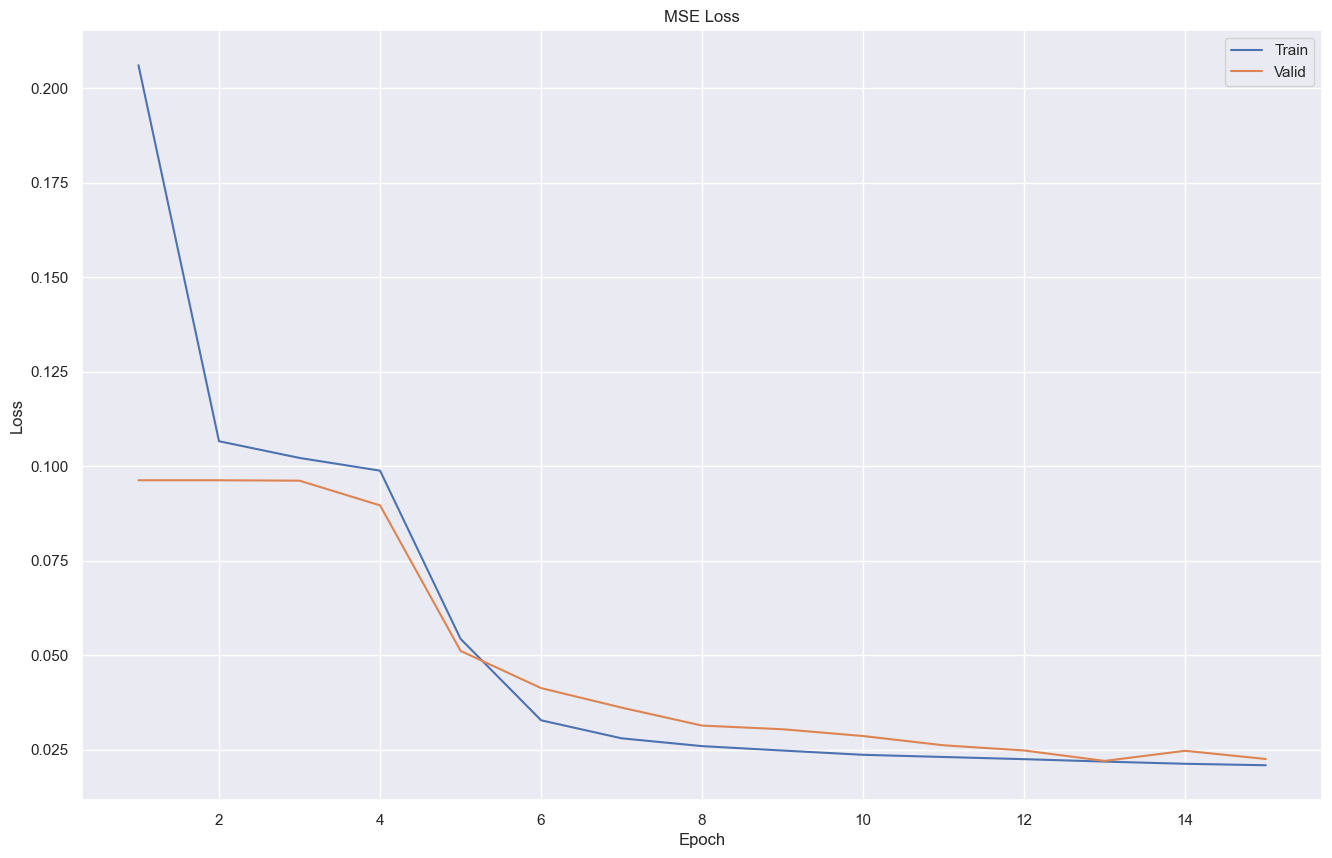

In [18]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'MSE Loss',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

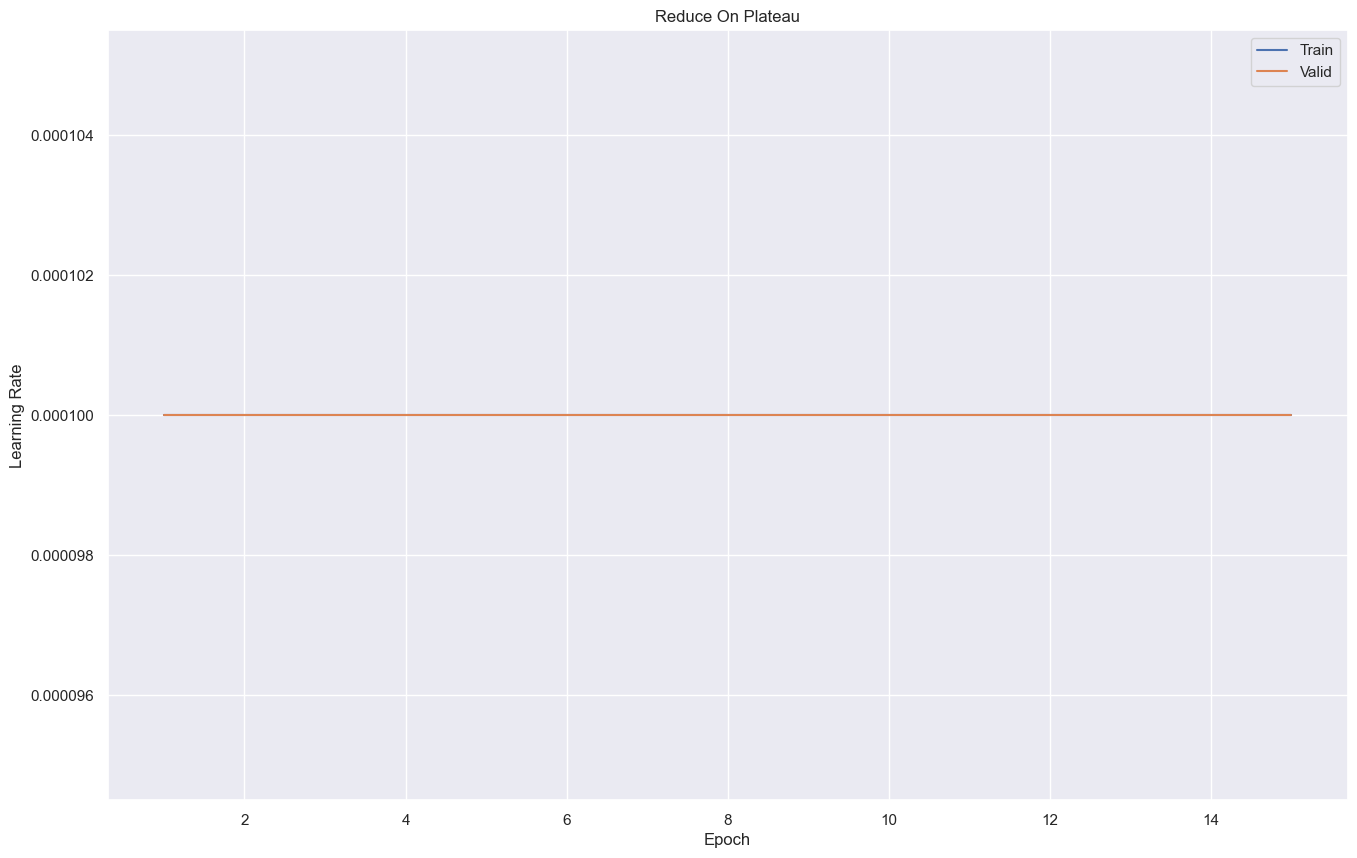

In [19]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

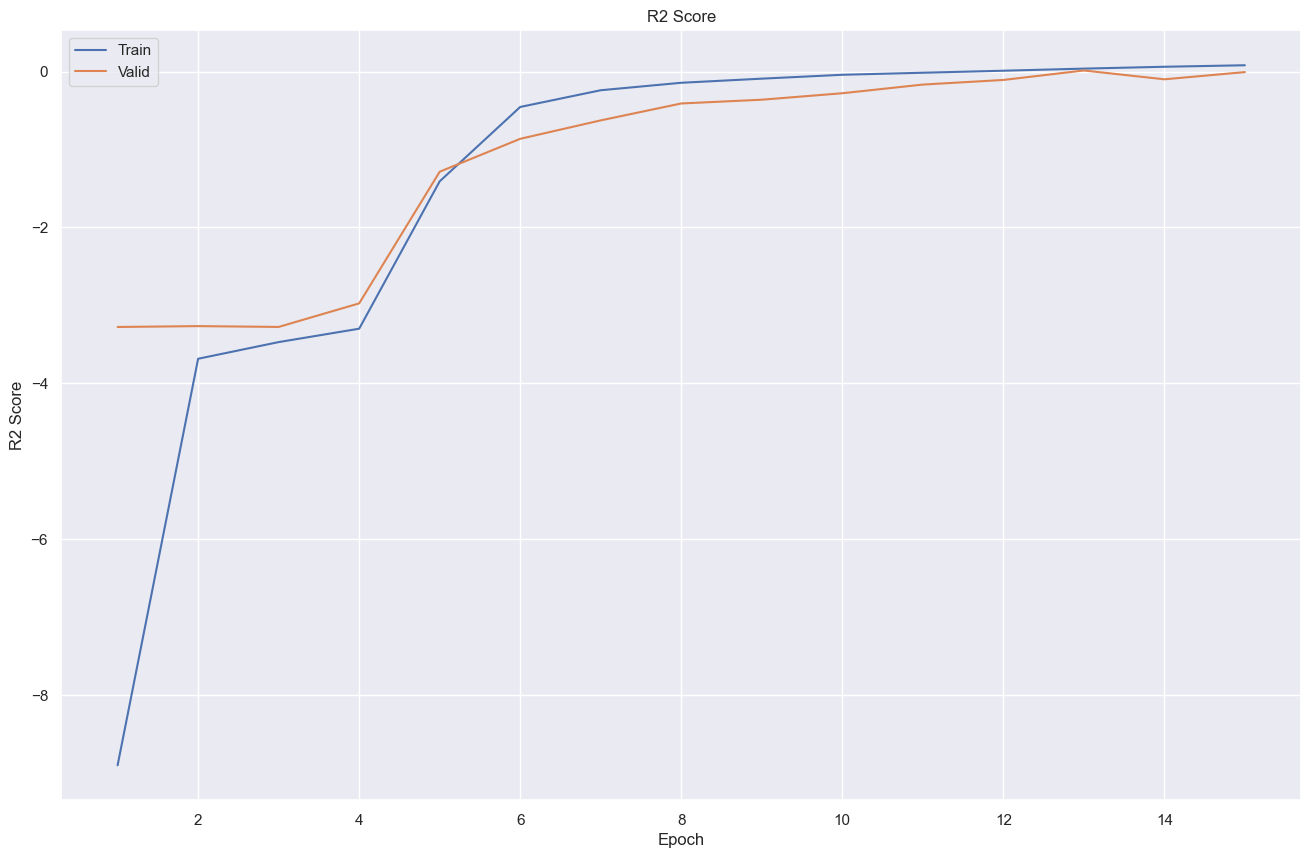

In [20]:
# Display the training and validation r2 score curves

cnn_plot.show_r2(
	report   = report,
	title    = 'R2 Score',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

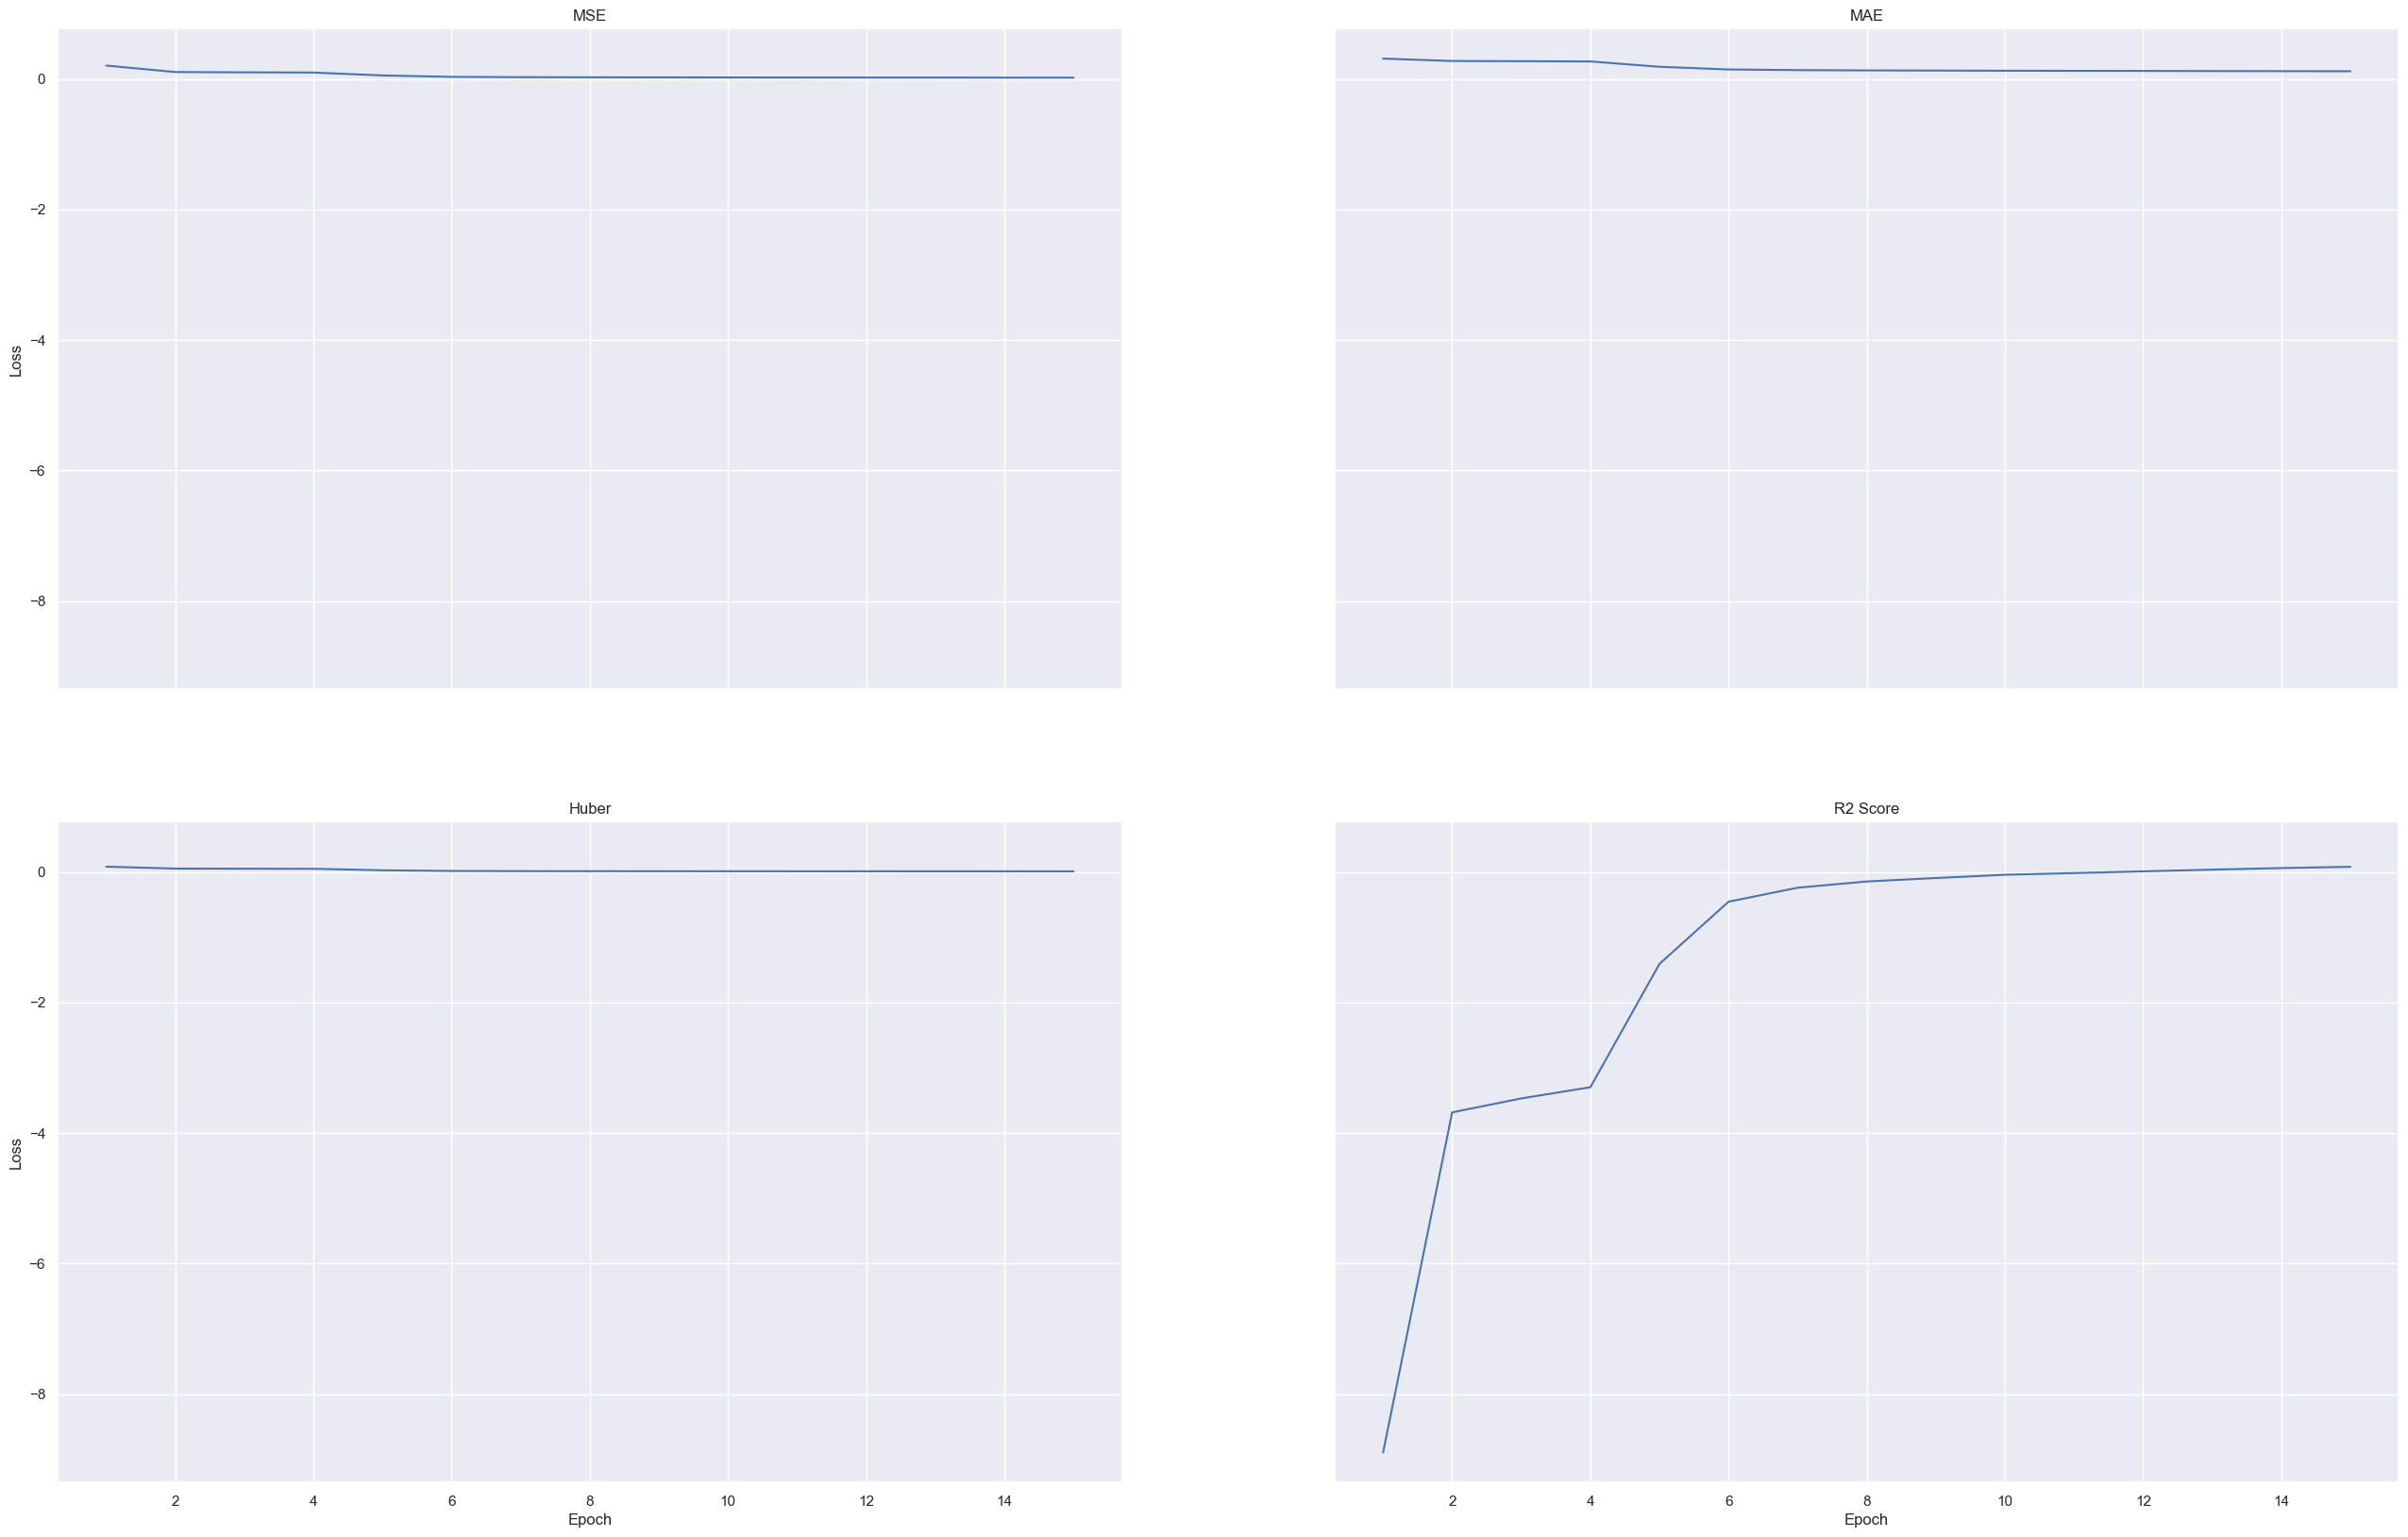

In [21]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

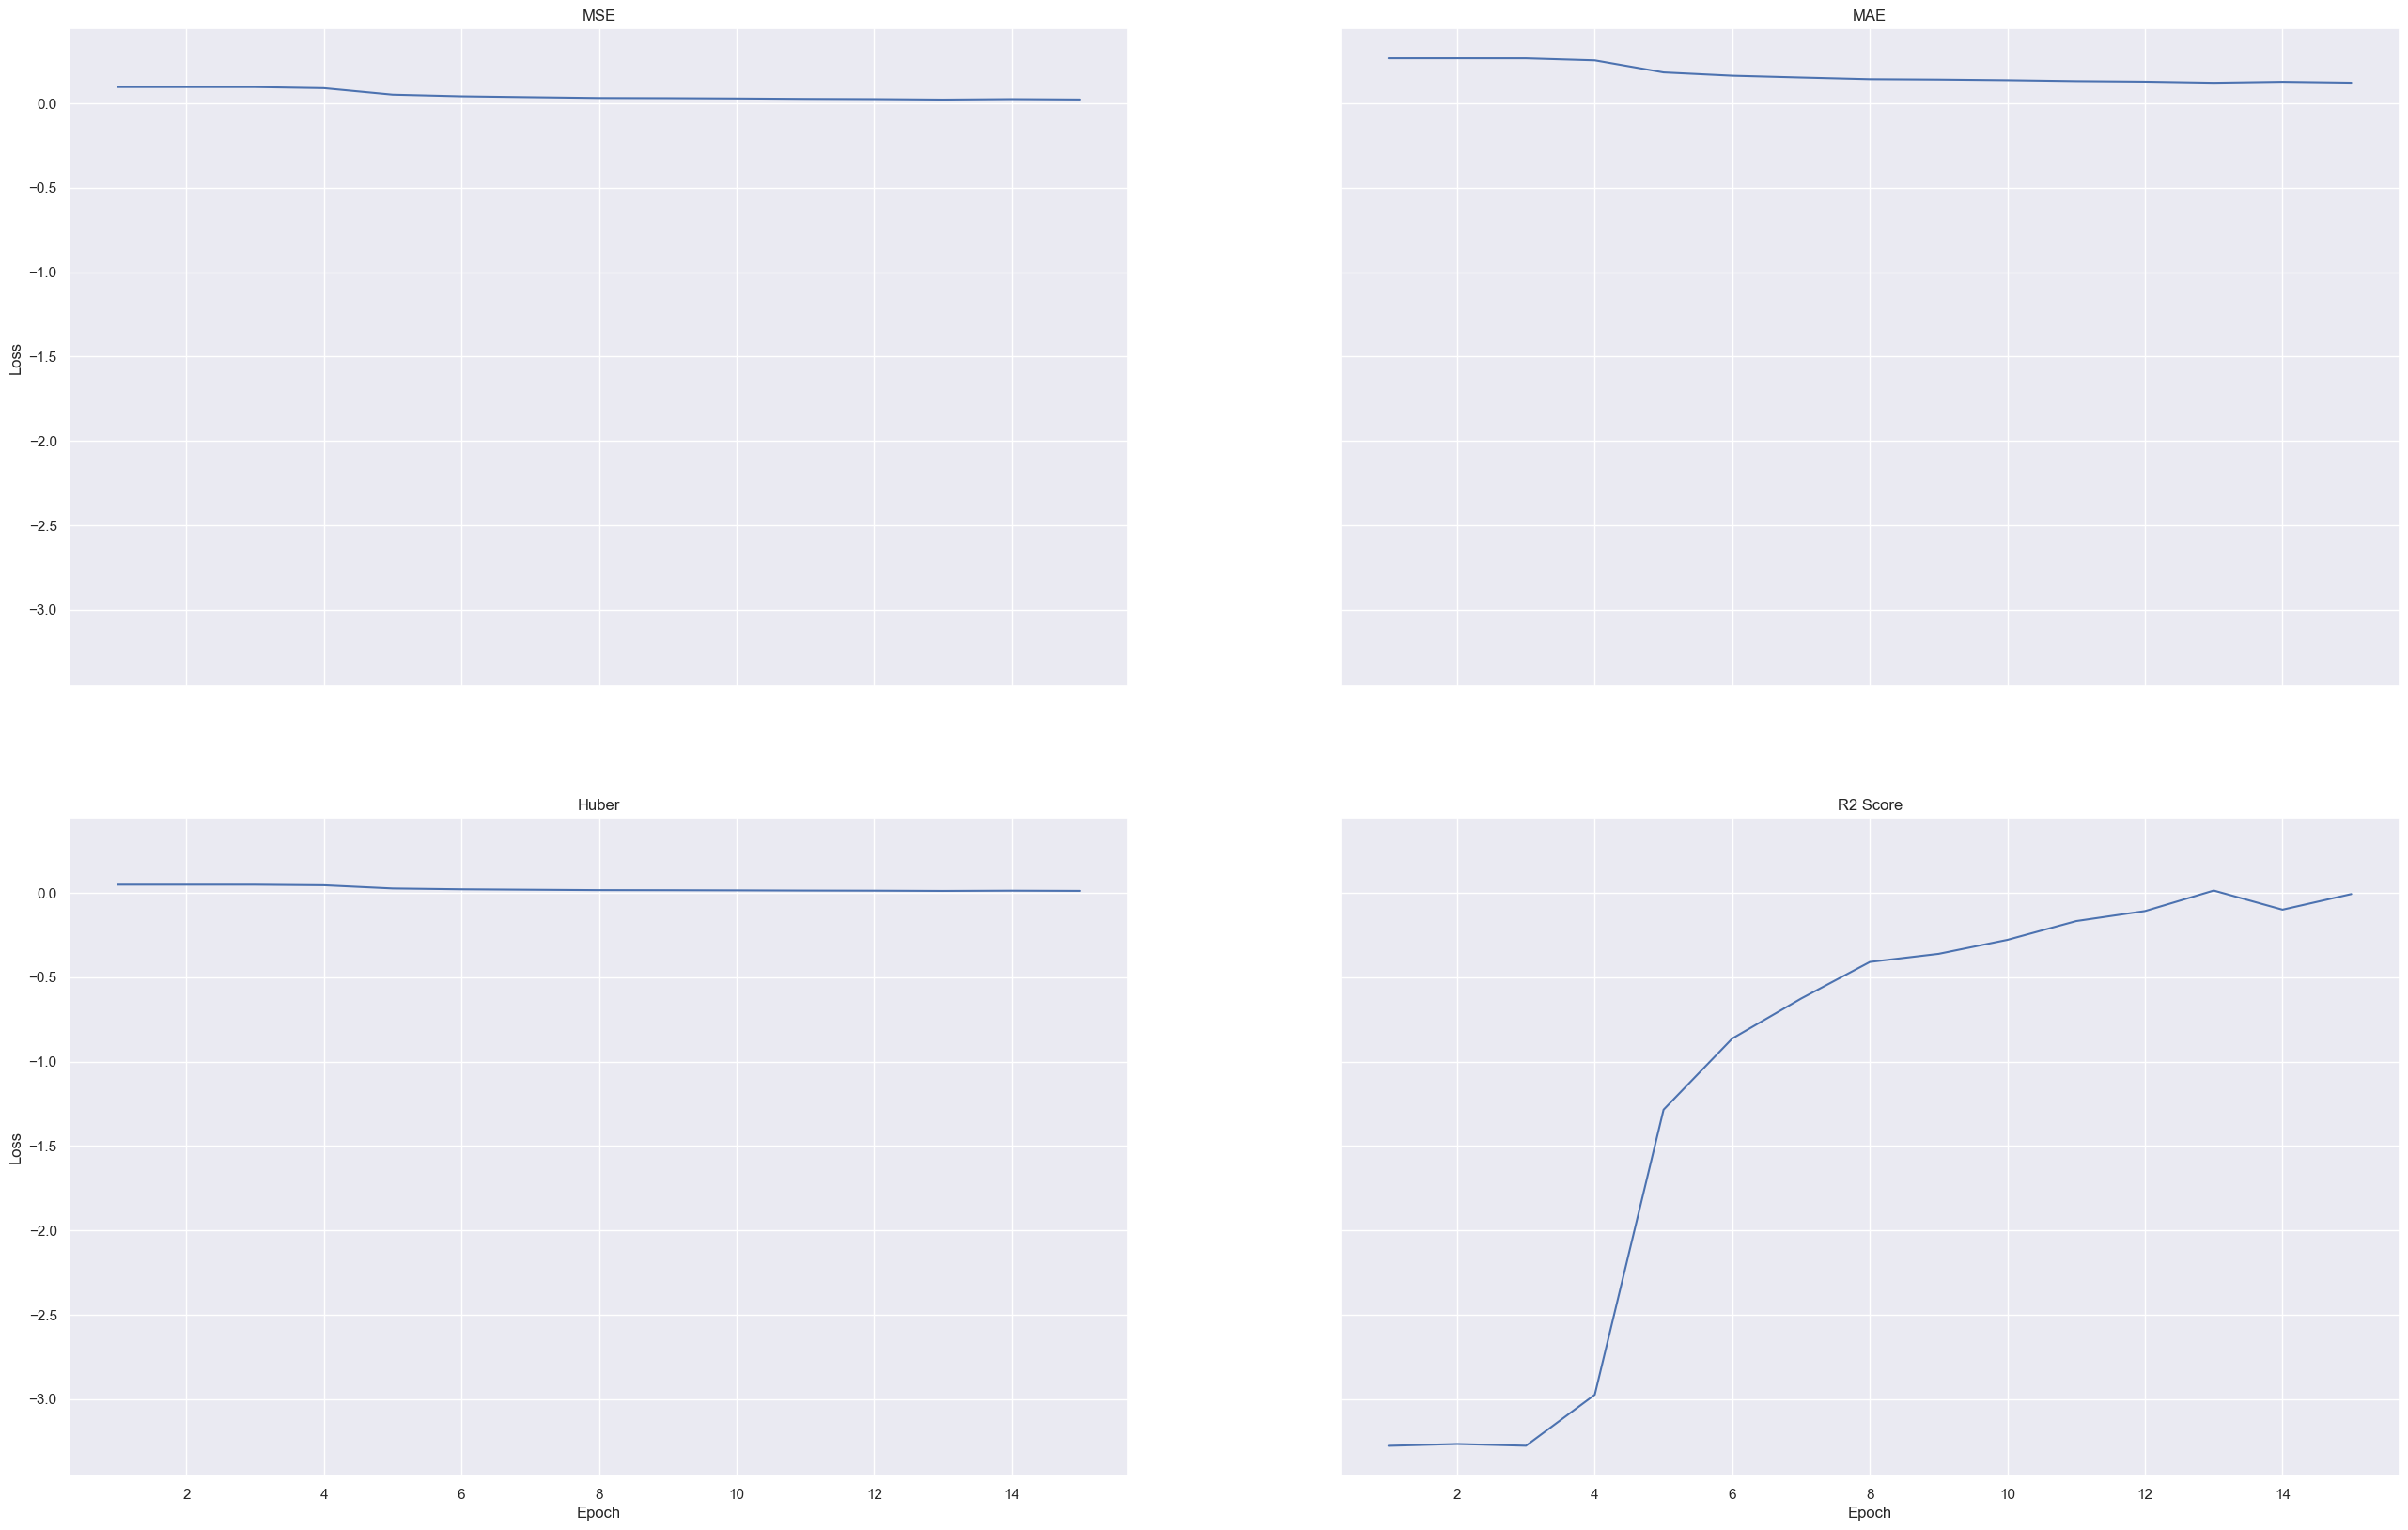

In [22]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

## 2.4 Evaluation

### 2.4.1 Last Model

In [23]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 15
 Loss : 0.02251


<All keys matched successfully>

In [24]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

  0%|          | 0/99 [00:00<?, ?it/s]

In [25]:
# Print the evaluation metrics

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score : -0.03353
MAE Loss :  0.12504
MSE Loss :  0.02350


In [26]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT1G32410.5
True : [ 0.20510    0.18102    0.16787    0.28243    0.20347    0.20686    0.18806    0.02412]
Pred : [ 0.35035    0.27910    0.30411    0.32682    0.31563    0.31259    0.23572    0.19501]
 MAE : [ 0.14526    0.09808    0.13624    0.04439    0.11216    0.10573    0.04766    0.17089]
 MSE : [ 0.02110    0.00962    0.01856    0.00197    0.01258    0.01118    0.00227    0.02920]
 R2  : [ 0.01314   -0.04289    0.02654   -0.16951   -0.01439   -0.14851   -0.06677   -0.04681]

Gene : AT1G61990.1
True : [ 0.43355    0.34533    0.36681    0.38701    0.41435    0.37768    0.24417    0.07647]
Pred : [ 0.24172    0.17654    0.18802    0.21389    0.20423    0.20951    0.14976    0.09820]
 MAE : [ 0.19183    0.16880    0.17879    0.17313    0.21012    0.16817    0.09441    0.02173]
 MSE : [ 0.03680    0.02849    0.03196    0.02997    0.04415    0.02828    0.00891    0.00047]
 R2  : [ 0.07811    0.13219    0.10367    0.13000    0.12846    0.14753    0.16433    0.12072]



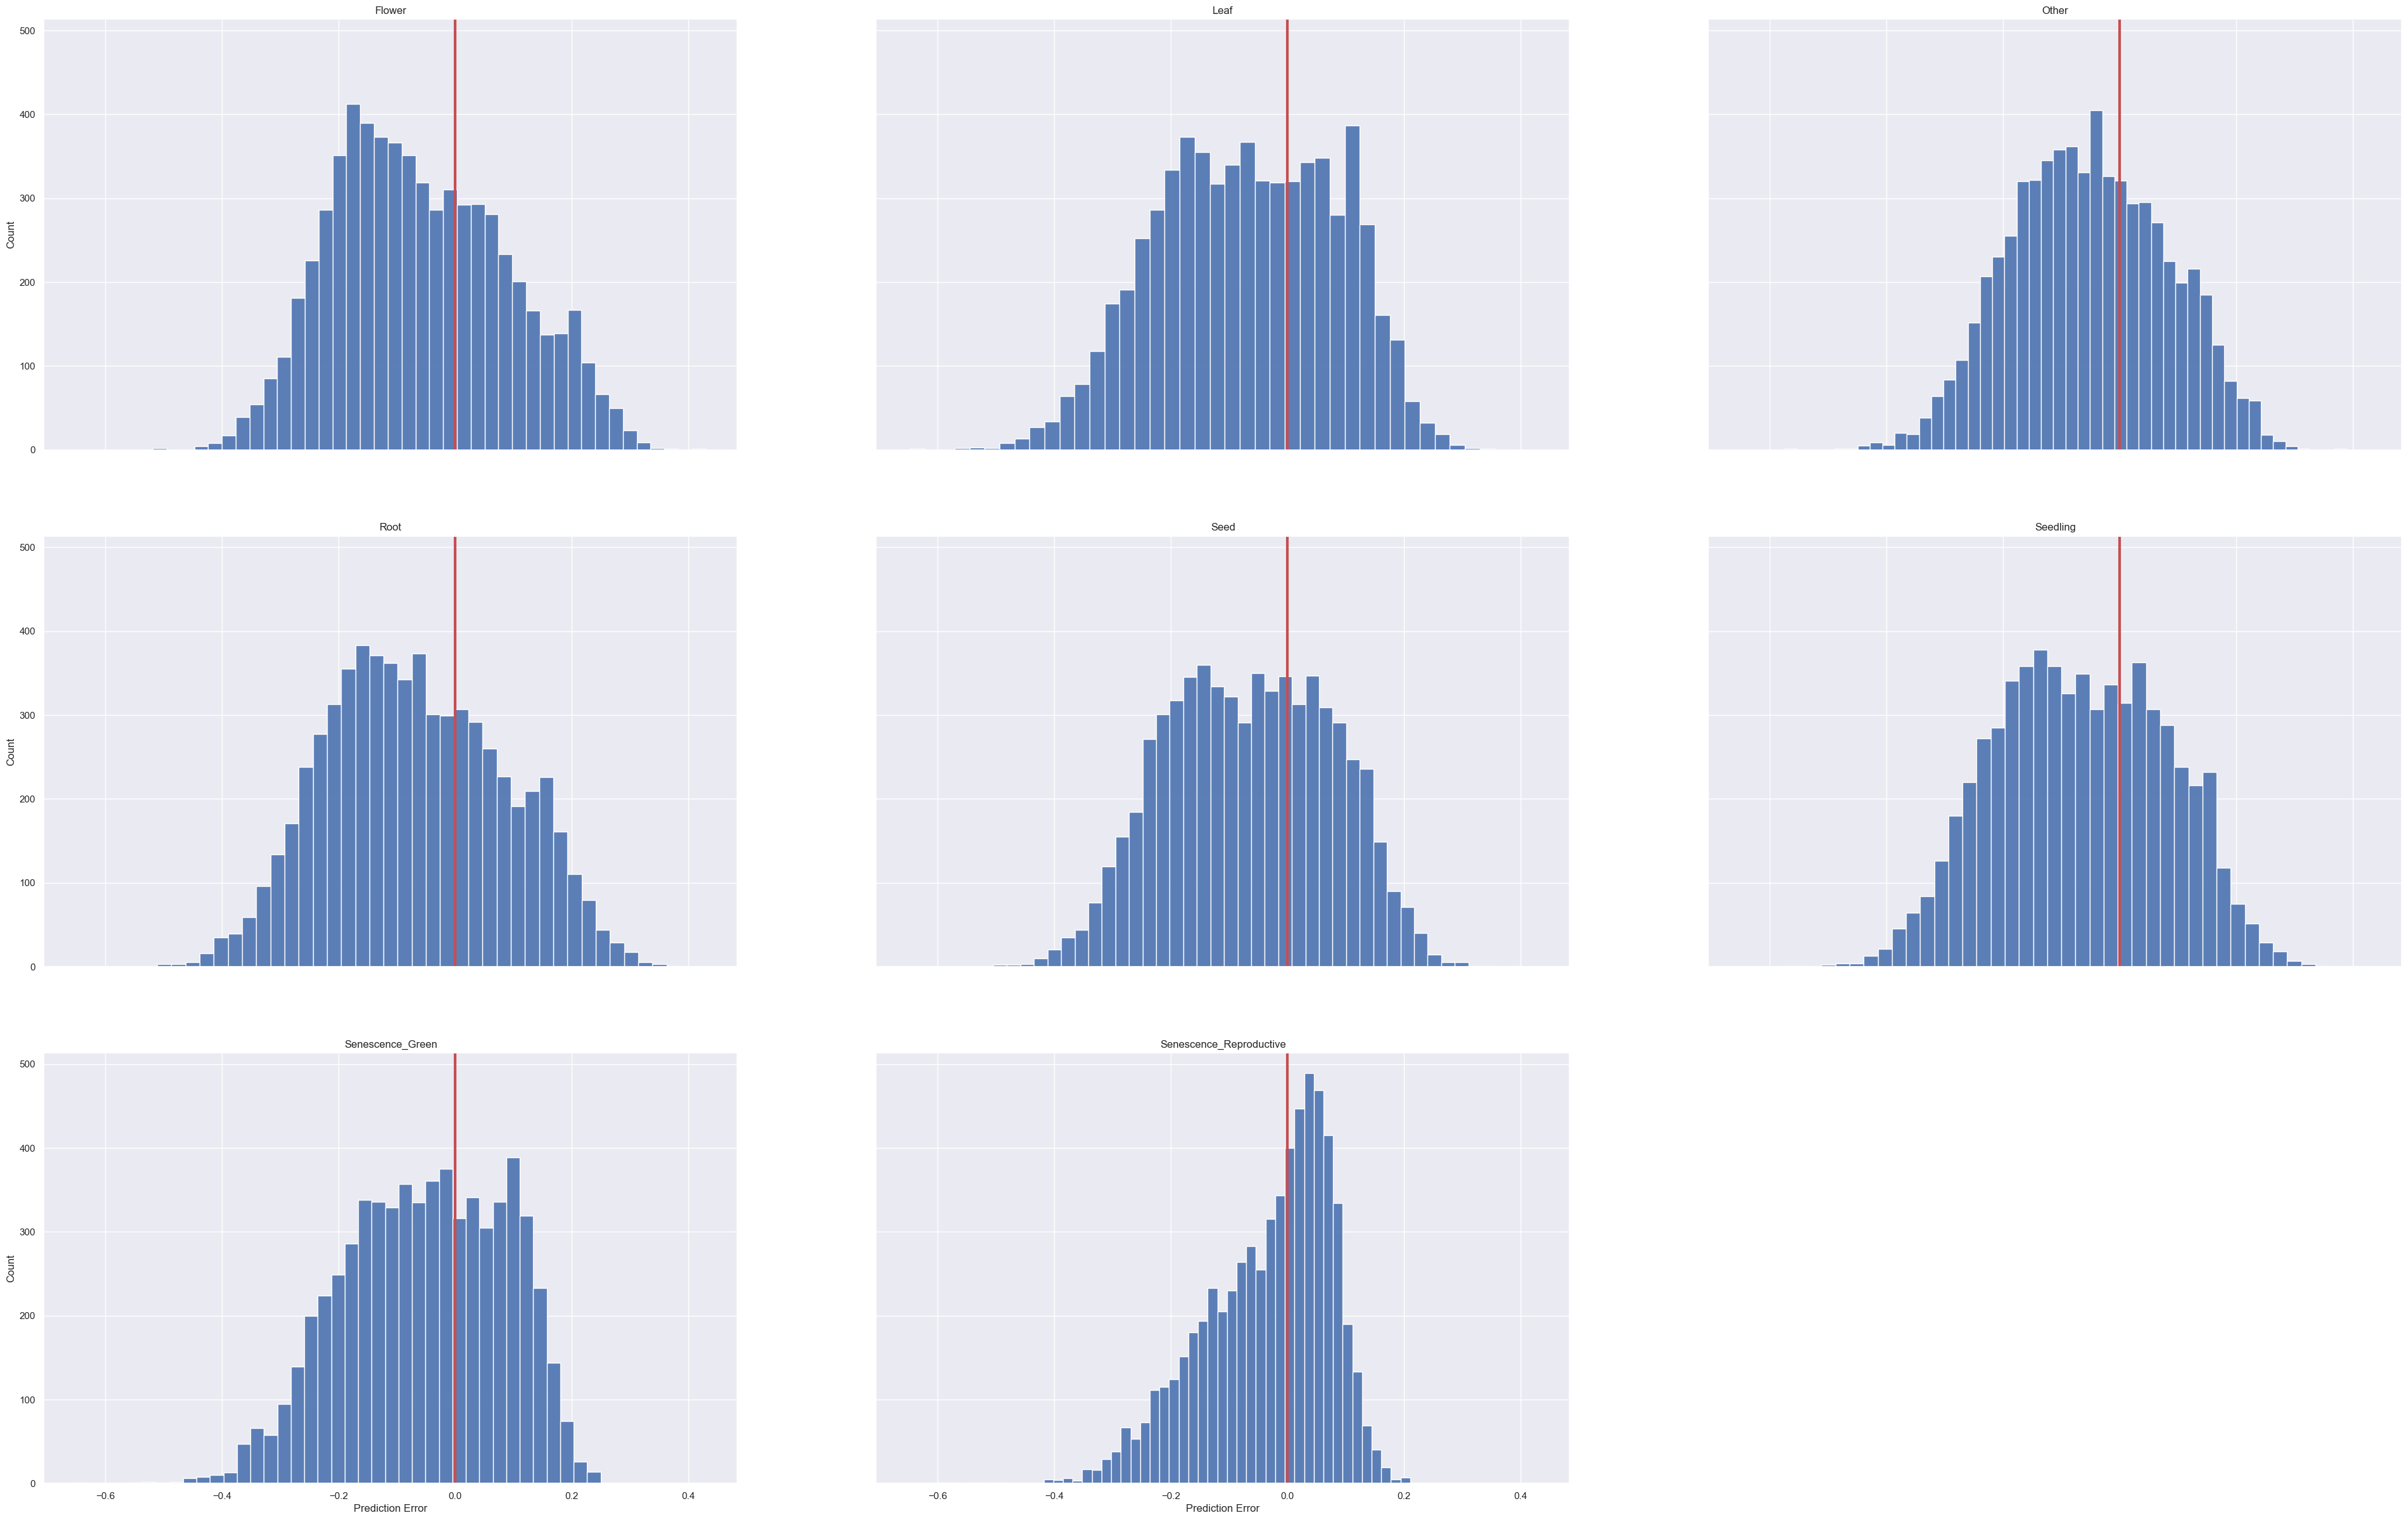

In [27]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-last')
)

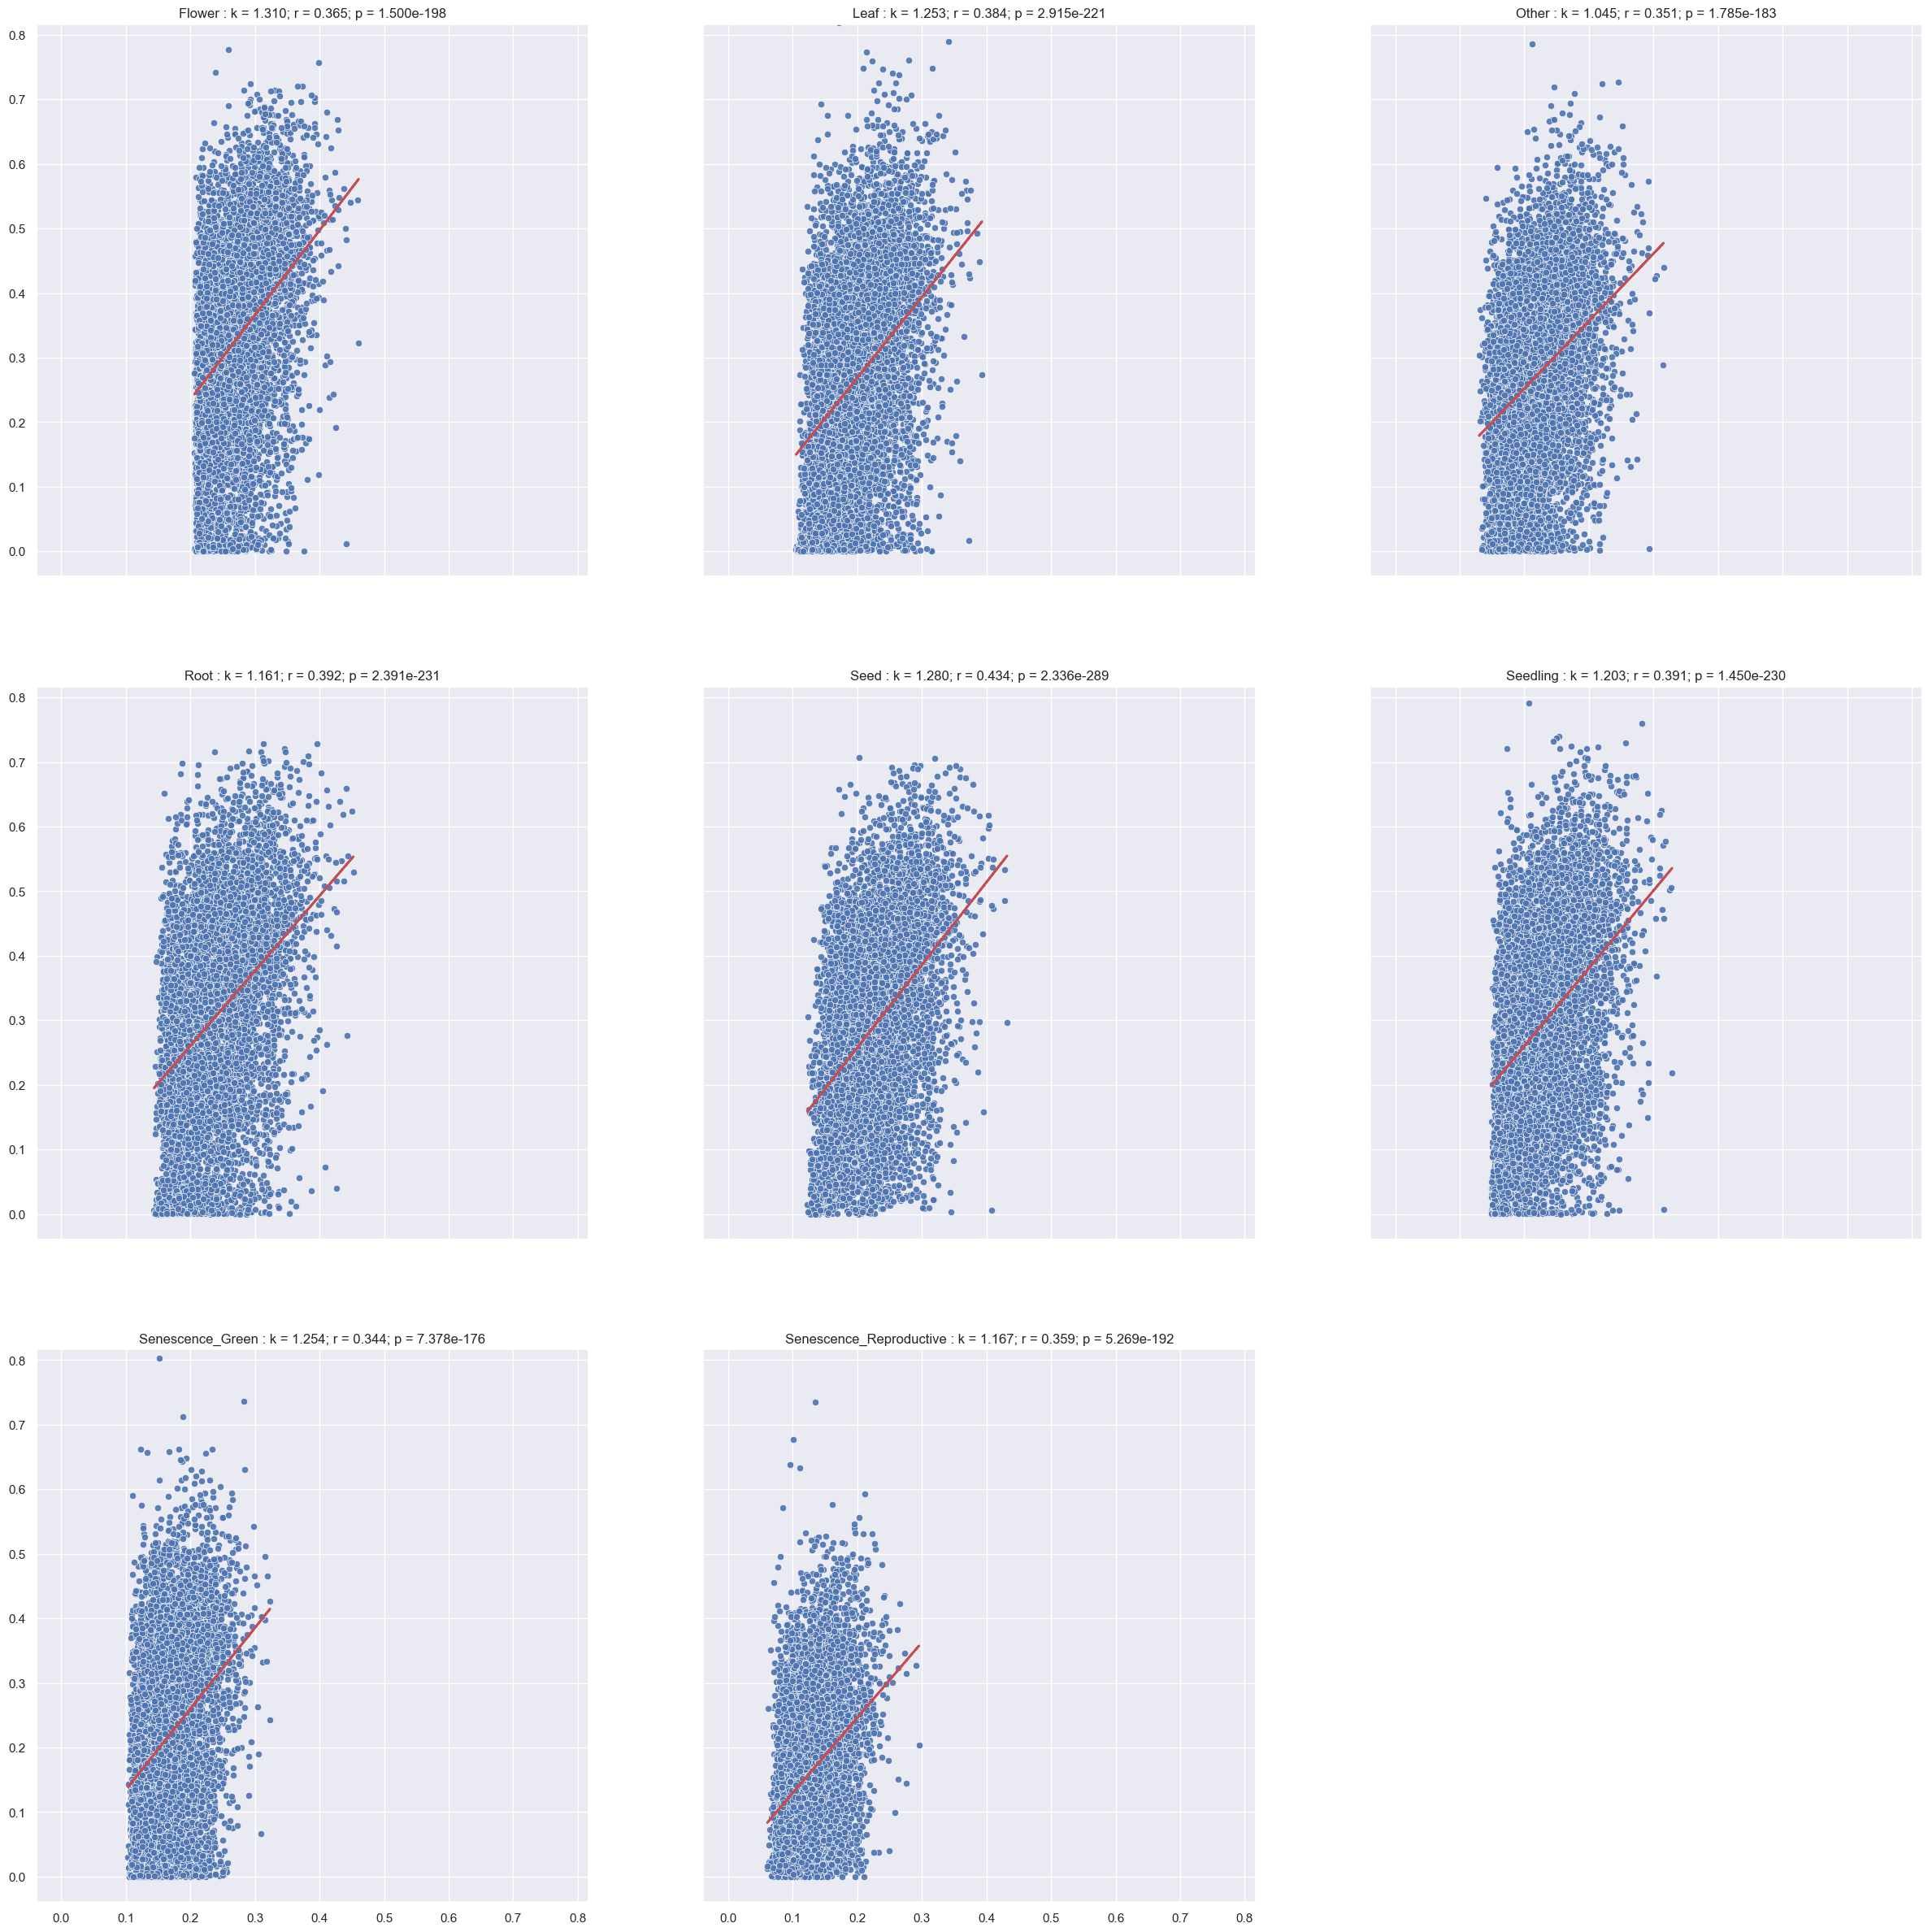

In [28]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-last')
)

In [29]:
# Display the evaluation accuracy, as well as the amount of over and under predictions

dataframe = cnn_util.display_regression_accuracy(
	report    = report['eval'],
	order     = tpm_order[config['output']['group0']],
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:6.2f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy :  47.16 %



Group  Total  Count  Accuracy  Avg MAE  Std MAE
7  senescence_reproductive   6336   4341     68.51     0.09     0.07
6         senescence_green   6336   4038     63.73     0.12     0.08
2                    other   6336   3491     55.10     0.12     0.08
4                     seed   6336   2904     45.83     0.13     0.09
5                 seedling   6336   2474     39.05     0.13     0.09
1                     leaf   6336   2396     37.82     0.14     0.10
3                     root   6336   2336     36.87     0.14     0.09
0                   flower   6336   1926     30.40     0.14     0.09

### 2.4.2 Best Model

In [30]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 13
 Loss : 0.02200


<All keys matched successfully>

In [31]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

  0%|          | 0/99 [00:00<?, ?it/s]

In [32]:
# Print the evaluation metrics

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score : -0.01185
MAE Loss :  0.12427
MSE Loss :  0.02298


In [33]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT3G56210.2
True : [ 0.45175    0.42270    0.36935    0.47108    0.45312    0.43826    0.42031    0.32490]
Pred : [ 0.31675    0.24727    0.25810    0.28785    0.29033    0.27999    0.19148    0.16945]
 MAE : [ 0.13500    0.17543    0.11124    0.18323    0.16279    0.15827    0.22883    0.15546]
 MSE : [ 0.01823    0.03077    0.01237    0.03357    0.02650    0.02505    0.05237    0.02417]
 R2  : [ 0.12242    0.09254    0.02853   -0.01185    0.12332    0.01048    0.12175    0.08933]

Gene : AT3G10910.1
True : [ 0.28184    0.18224    0.34995    0.48827    0.29297    0.36446    0.25292    0.11381]
Pred : [ 0.25911    0.18393    0.22037    0.22605    0.21028    0.21355    0.13867    0.12388]
 MAE : [ 0.02273    0.00168    0.12958    0.26222    0.08269    0.15090    0.11425    0.01007]
 MSE : [ 0.00052    0.00000    0.01679    0.06876    0.00684    0.02277    0.01305    0.00010]
 R2  : [ 0.03350    0.02730    0.00279    0.00342    0.08447   -0.01016    0.03862    0.10256]



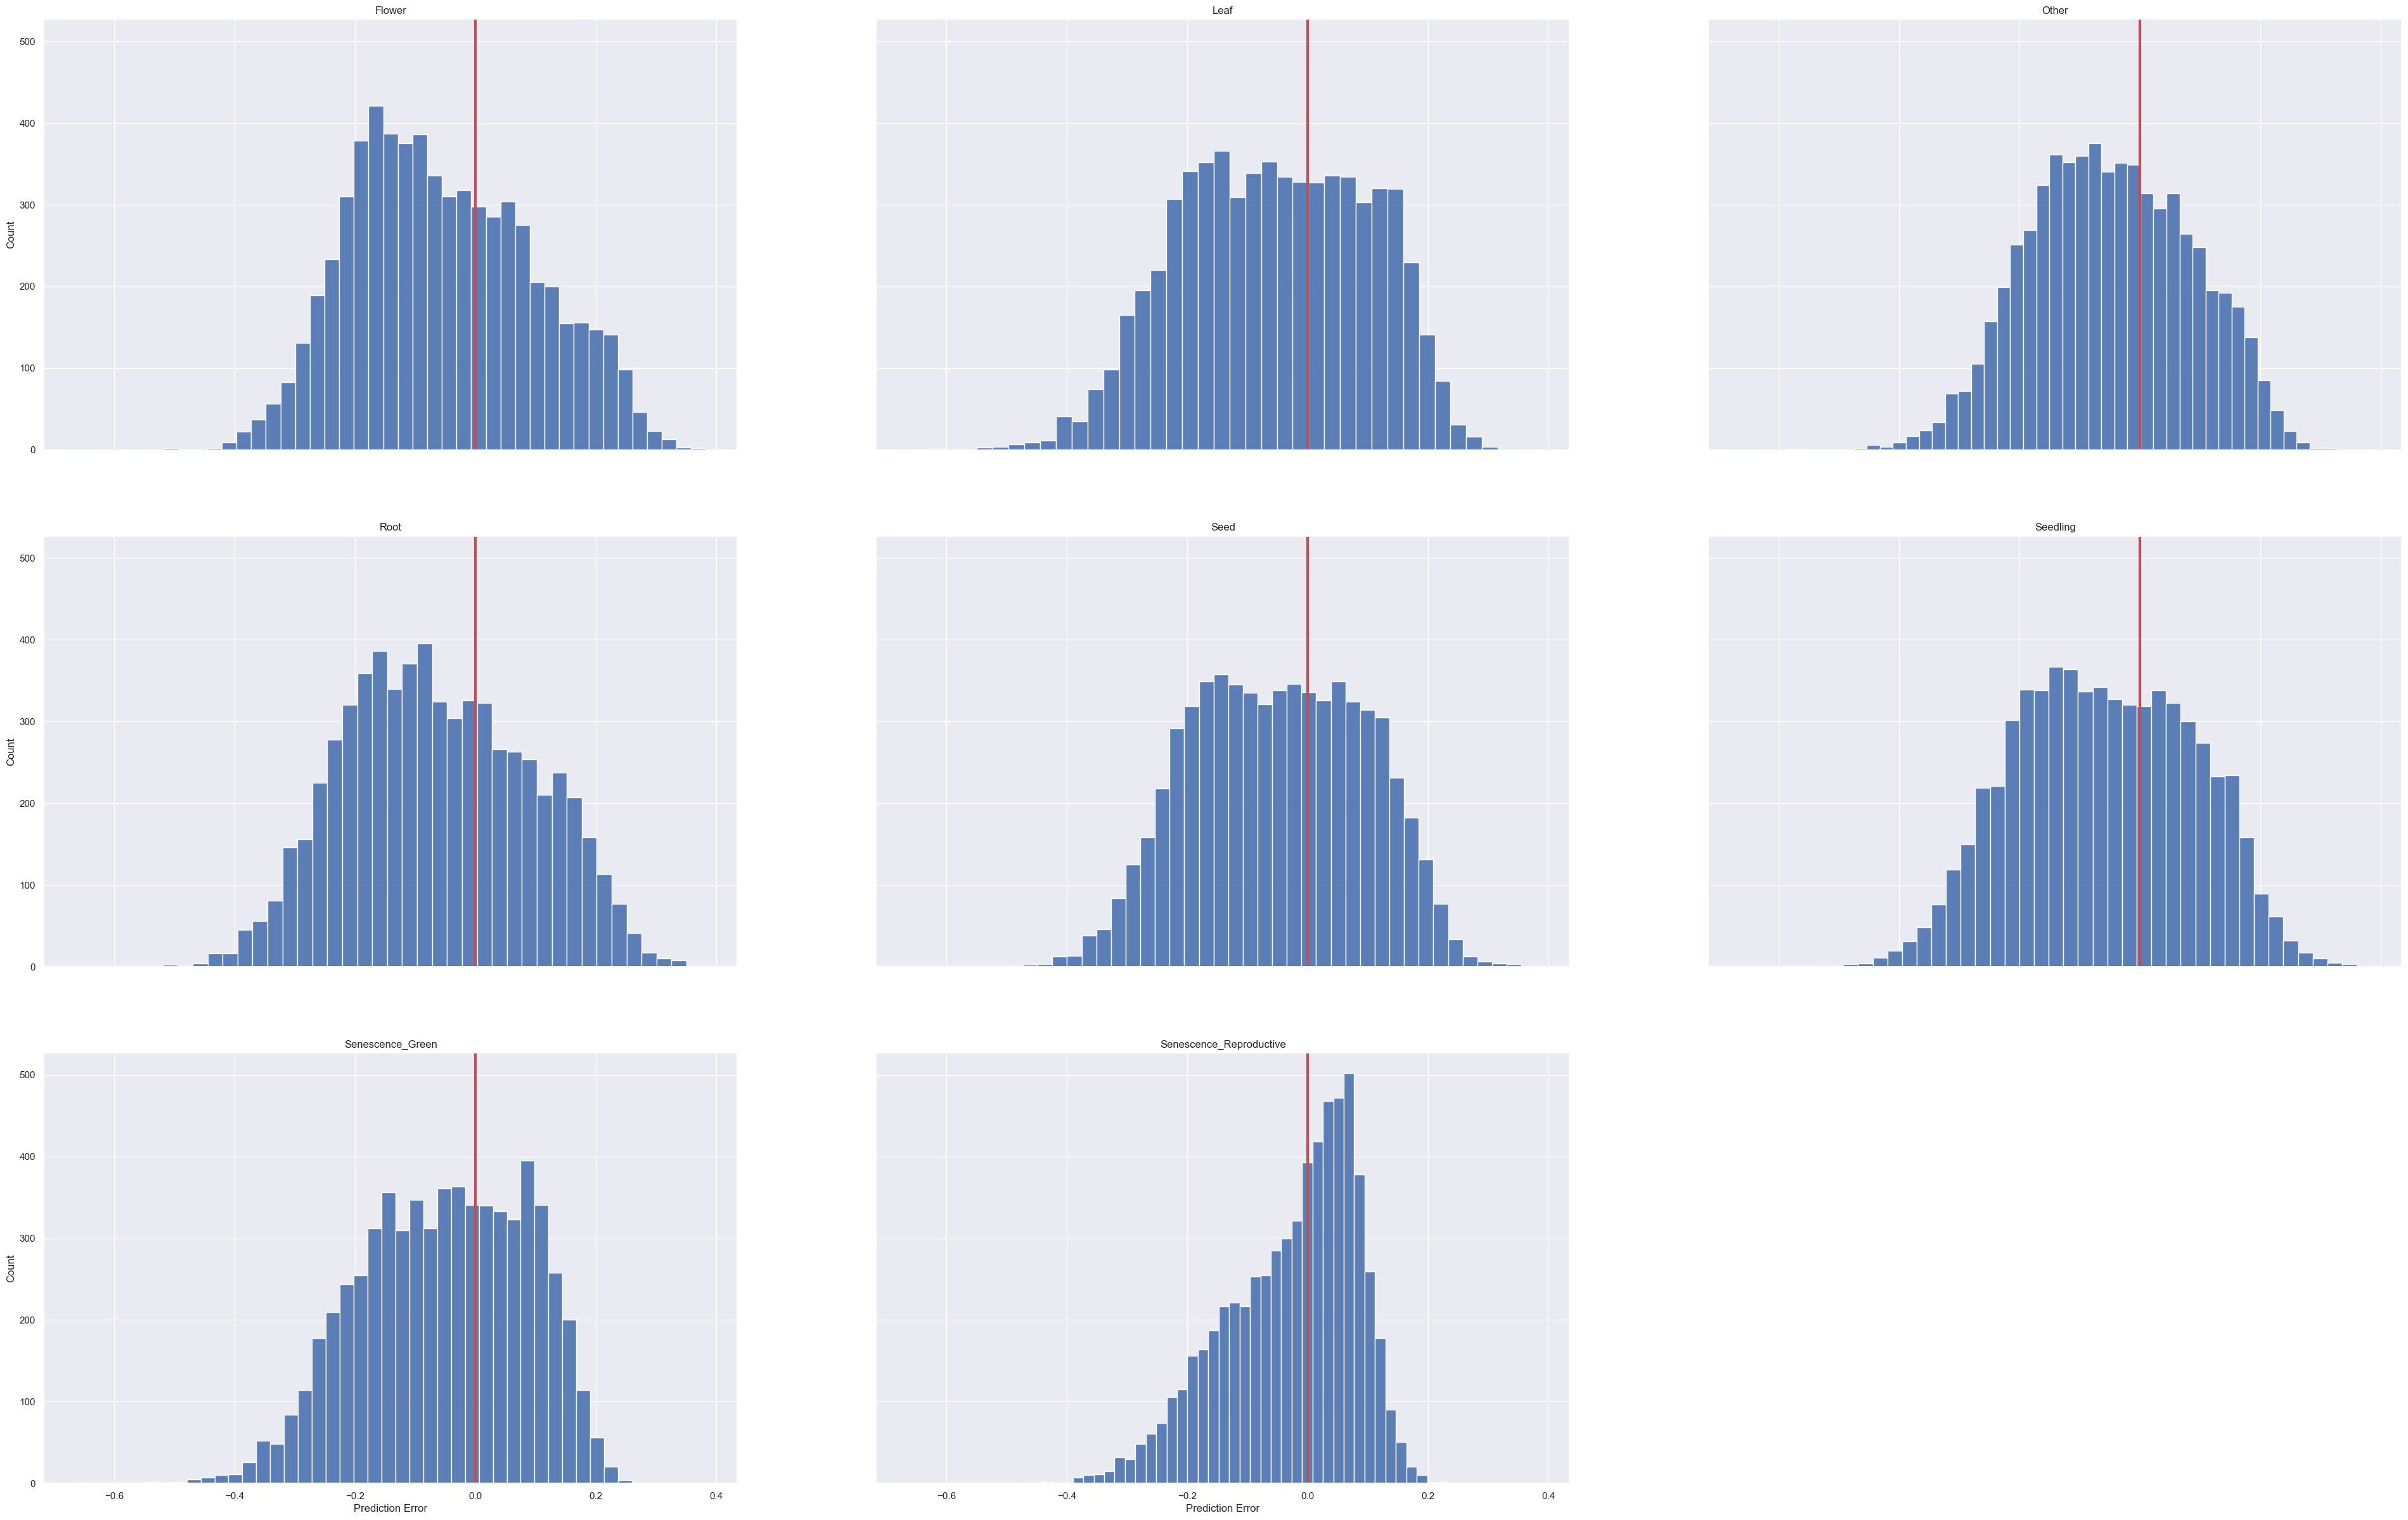

In [34]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

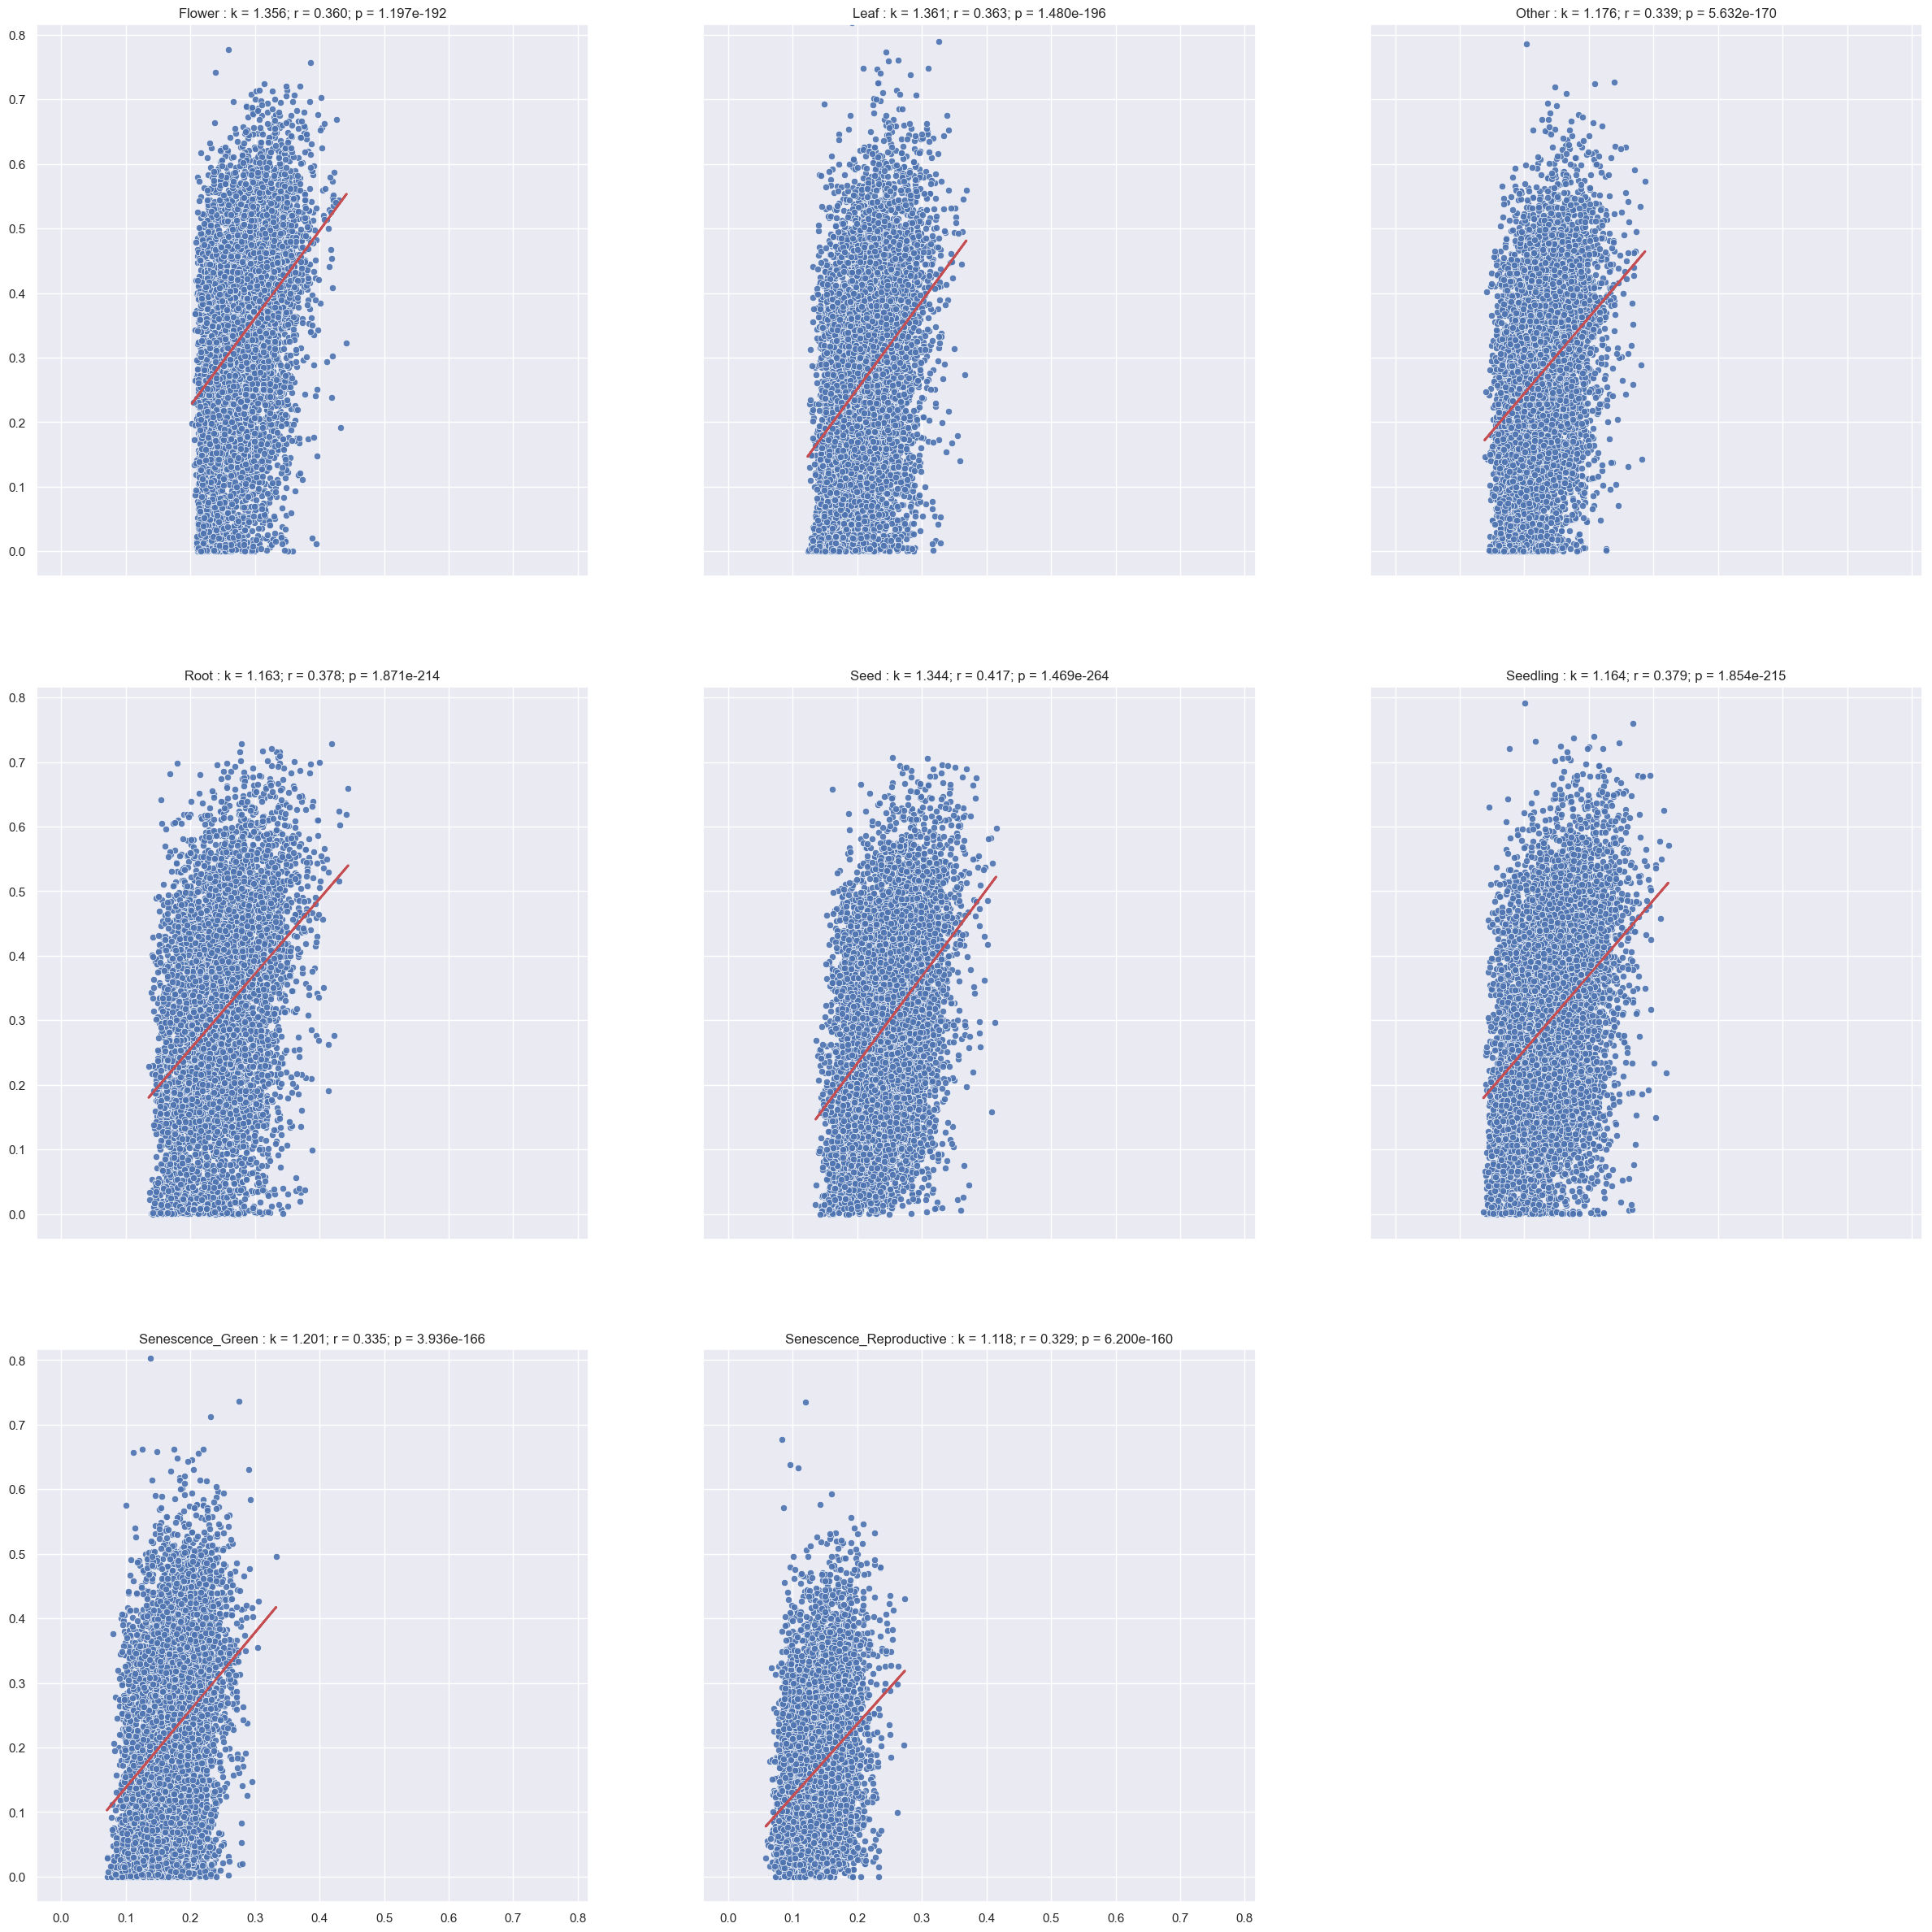

In [35]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = tpm_order[config['output']['group0']],
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

In [36]:
# Display the evaluation accuracy, as well as the amount of over and under predictions

dataframe = cnn_util.display_regression_accuracy(
	report    = report['eval'],
	order     = tpm_order[config['output']['group0']],
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:6.2f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy :  46.90 %



Group  Total  Count  Accuracy  Avg MAE  Std MAE
7  senescence_reproductive   6336   4277     67.50     0.09     0.07
6         senescence_green   6336   3999     63.12     0.12     0.09
2                    other   6336   3473     54.81     0.12     0.08
4                     seed   6336   2908     45.90     0.13     0.08
5                 seedling   6336   2467     38.94     0.13     0.09
1                     leaf   6336   2408     38.01     0.14     0.09
3                     root   6336   2332     36.81     0.14     0.09
0                   flower   6336   1909     30.13     0.13     0.09